In [1]:
import os
os.environ['KAGGLE_USERNAME']="simransohal"
os.environ['KAGGLE_KEY']="3aa7697cd9a4ba2a3715c4a29c0f0cb6"

In [2]:
!kaggle datasets download -d muhammadkhalid/sign-language-for-numbers

sign-language-for-numbers.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
import zipfile
with zipfile.ZipFile('sign-language-for-numbers.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.optim import Adam

import torchvision.datasets as datasets
import torch.utils.data as td
import numpy as np
import matplotlib.pyplot as plt

import torch.nn.functional as F
from matplotlib import image
from matplotlib import pyplot
import time

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
import torch
import torchvision

models = models = torchvision.models.mobilenet_v3_small(pretrained=False)
#models = [torchvision.models.resnet18(pretrained=False)]
models.fc = nn.Linear(models.classifier[0].in_features, 11)

In [8]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4772, 0.4772, 0.4772], std=[-0.3425, -0.3425, -0.3425]),
])

In [9]:
dataset = datasets.ImageFolder(r"Sign Language for Numbers", transform=preprocess)
train_size = int(0.7 * len(dataset))
val_size=int(0.1*len(dataset))
test_size = len(dataset) - (train_size+val_size)
train_dataset,validation_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size,val_size,test_size])

In [10]:
from torch.utils.data import DataLoader

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader=DataLoader(validation_dataset,batch_size=batch_size,shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [11]:
optimizers =Adam(models.parameters(), lr=0.001) 
criterion = nn.CrossEntropyLoss()

In [12]:
learning_rate = 0.001
num_epochs = 10
batch_size = 64

In [13]:
import time
training_loss = []
validation_loss = []
training_accuracy = []
validation_accuracy = []
models.to(device)
start_time=time.time()
for epoch in range(num_epochs):
    running_training_loss = 0.0
    running_training_accuracy = 0.0
    
    models.train()
    for i, (inputs, labels) in enumerate(train_dataloader):
        optimizers.zero_grad()
        inputs = inputs.to(device)  
        labels = labels.to(device) 
        outputs = models(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizers.step()
        running_training_loss += loss.item()
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1  }/{len(train_dataloader)}], Loss: {loss.item()}')
        _, preds = torch.max(outputs, 1)
        running_training_accuracy += torch.sum(preds == labels.data)
    
    epoch_training_loss = running_training_loss / len(train_dataloader)
    epoch_training_accuracy = running_training_accuracy / len(train_dataloader.dataset)
    training_loss.append(epoch_training_loss)
    training_accuracy.append(epoch_training_accuracy)
    
    running_validation_loss = 0.0
    running_validation_accuracy = 0.0
    models.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(validation_dataloader):
            inputs = inputs.to(device)  
            labels = labels.to(device)
            outputs = models(inputs)
            loss = criterion(outputs, labels)
            running_validation_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            running_validation_accuracy += torch.sum(preds == labels.data)
    
    epoch_validation_loss = running_validation_loss / len(train_dataloader)
    epoch_validation_accuracy = running_validation_accuracy / len(validation_dataloader.dataset)
    validation_loss.append(epoch_validation_loss)
    validation_accuracy.append(epoch_validation_accuracy)
    print('Epoch [{}/{}], Training Loss: {}, Training Accuracy: {}, Validation Loss: {}, Validation Accuracy: {}'
          .format(epoch+1, num_epochs, epoch_training_loss, epoch_training_accuracy, epoch_validation_loss, epoch_validation_accuracy))
print("#########Time Taken{}#########".format(time.time()-start_time))

Epoch [1/10], Step [100/181], Loss: 0.9728407859802246
Epoch [1/10], Training Loss: 1.5485862913381987, Training Accuracy: 0.5141125321388245, Validation Loss: 0.4247440501471251, Validation Accuracy: 0.0981818214058876
Epoch [2/10], Step [100/181], Loss: 0.2409961223602295
Epoch [2/10], Training Loss: 0.38928963474476536, Training Accuracy: 0.8743722438812256, Validation Loss: 0.5110976814565079, Validation Accuracy: 0.10060606151819229
Epoch [3/10], Step [100/181], Loss: 0.2637699842453003
Epoch [3/10], Training Loss: 0.20457119264161389, Training Accuracy: 0.9343722462654114, Validation Loss: 0.10366928709146067, Validation Accuracy: 0.7478787899017334
Epoch [4/10], Step [100/181], Loss: 0.07456962764263153
Epoch [4/10], Training Loss: 0.13405219139788527, Training Accuracy: 0.9585281014442444, Validation Loss: 0.03349043223080714, Validation Accuracy: 0.9290909171104431
Epoch [5/10], Step [100/181], Loss: 0.2744734585285187
Epoch [5/10], Training Loss: 0.09701440037737565, Training

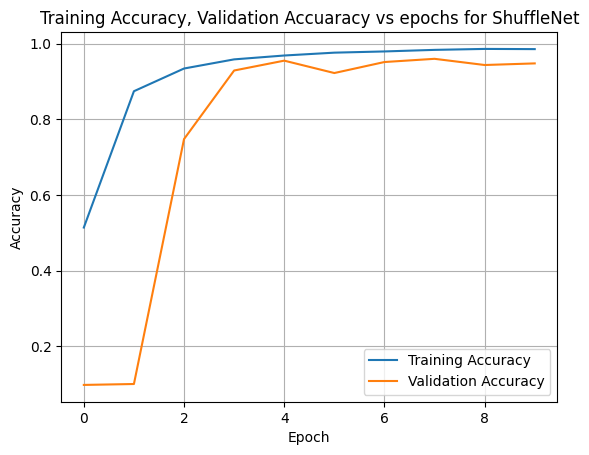

In [14]:
training_accuracy_tensor = torch.tensor(training_accuracy)
validation_accuracy_tensor = torch.tensor(validation_accuracy)

plt.plot(training_accuracy_tensor.to('cpu'), label='Training Accuracy')
plt.plot(validation_accuracy_tensor.to('cpu'), label='Validation Accuracy')
plt.title('Training Accuracy, Validation Accuaracy vs epochs for ShuffleNet')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

Test Accuracy: 0.9533333333333334
[[287   0   1   0   0   0   0   0   0   0   3]
 [  1 280   0   0   0   0   0   1   0   0   8]
 [  0   0 272   1   0   0   1  10   0   0   8]
 [  1   0   3 293   0   1   1   0   0   0   1]
 [  0   0   0   0 260   3  11   8   1   0   8]
 [  0   0   0   1   1 305   1   0   0   0   9]
 [  2   0   4   0   1   0 282   6   0   0   4]
 [  0   0   1   0   0   0   0 304   1   0   0]
 [  2   1   0   0   1   0   0   3 284   0   7]
 [  0   0   0   0   1   1   0   2   5 280  14]
 [ 11   0   1   0   0   0   0   2   0   0 299]]


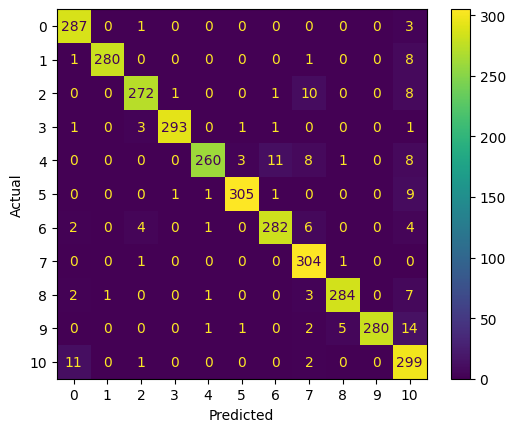

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       291
           1       1.00      0.97      0.98       290
           2       0.96      0.93      0.95       292
           3       0.99      0.98      0.98       300
           4       0.98      0.89      0.94       291
           5       0.98      0.96      0.97       317
           6       0.95      0.94      0.95       299
           7       0.90      0.99      0.95       306
           8       0.98      0.95      0.96       298
           9       1.00      0.92      0.96       303
          10       0.83      0.96      0.89       313

    accuracy                           0.95      3300
   macro avg       0.96      0.95      0.95      3300
weighted avg       0.96      0.95      0.95      3300



In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

models.eval()
with torch.no_grad():
    test_preds = []
    test_labels = []
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = models(inputs)
        _, preds = torch.max(outputs, 1)
        test_preds.extend(preds.tolist())
        test_labels.extend(labels.tolist())

test_acc = accuracy_score(test_labels, test_preds)
print('Test Accuracy: {}'.format(test_acc))

#target_names = list(data_loader_train.class_to_idx.keys())
cm = confusion_matrix(test_labels, test_preds)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
#sns.heatmap(cm, annot=True, cmap='Oranges')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(classification_report(test_labels, test_preds))

In [16]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

models.to('cuda')

models = torch.nn.Sequential(*(list(models.children())[:-1]))

models.eval()

features = []
labels = []
for images, target in test_dataloader:
    images = images.to('cuda')
    with torch.no_grad():
        output = models(images)
        features.append(output.squeeze().cpu().numpy())
        labels.append(target.cpu().numpy())

features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)

# reshape the features array to have two dimensions
n_samples = features.shape[0]
n_features = np.prod(features.shape[1:])
features = features.reshape((n_samples, n_features))

tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=2000)
tsne_features = tsne.fit_transform(features)

target_names = list(dataset.class_to_idx.keys())

cmap = plt.cm.get_cmap('tab10', len(target_names)-1)

u = False

plt.figure(figsize=(10, 10))
for i, target_name in enumerate(target_names):
    if target_name != "unknown":
        indices = labels == i
        plt.scatter(tsne_features[indices, 0], tsne_features[indices, 1], label=target_name, c=cmap(i))
plt.scatter(tsne_features[u, 0], tsne_features[u, 1], label="unknown", c="k")
plt.legend()
plt.show()


RuntimeError: ignored